In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 1. Introduction

In this project, the aim is to correctly classify whether a photo of a human face is photoshopped or not. In other words, this task is a binary classification task.

Several machine learning methods can be used to achieve this goal. Some of them are logistic regression, decision trees, and random forest. However, recent developments in technology enabled us to use artificial neural networks or deep learning. These networks require great computational power which we have now. 

There are various types of deep neural networks. However, AlexNet showed that convolutional neural networks work best for image classification tasks [1]. 

Deep convolutional neural networks like AlexNet requires great computational power to train. This is not possible in a basic laptop. Therefore, transfer learning is widely used [2]. In transfer learning, a pretrained model is downloaded and implemented. Besides other machine learning models, a deep convolutional network with transfer learning is also suitable for this task.


## 2. Data

Data consists of two files, training and unknown. Training file has 891 real photos and 463 fake photos. Unknown file has 481 photos without any label. The photos have the size 600x600.

In [2]:
import numpy as np
import tensorflow as tf
import random as rn

np.random.seed(36)

rn.seed(42)


from keras import backend as K
tf.set_random_seed(26)

sess = tf.Session(graph=tf.get_default_graph())
K.set_session(sess)

Using TensorFlow backend.


In order to get reproducible results, seeds for numpy, random, and tensorflow library are set to 36, 42, and 26, respectively. 

In [ ]:
bn_root_path_training = 'drive/My Drive/data/training/'
bn_root_path_validation='drive/My Drive/data/validation/'

The training data is seperated into 2 files by hand. This is done to avoid validation data to get augmented. Raw data is split into training and validation data by 0.8 and 0.2 factors, respectively.

At first, the same ImageDataGenerator was used for both validation and training data because ImageDataGenerator has 'subset' argument. This argument can be set to training or validation. However, since the data comes from the same directory and generator, this approach leads to augmented validation data which is not wanted.

In [4]:

from keras.preprocessing.image import ImageDataGenerator 
batch_size=32
img_height=600
img_width=600

generator = ImageDataGenerator(rescale = 1./255,
                               validation_split=0, 
                              rotation_range = 20, 
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               zoom_range = 0.1,
                               horizontal_flip = True,
                                ) 
val_generator=ImageDataGenerator(rescale = 1./255)

train_data = generator.flow_from_directory(
    bn_root_path_training,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    ) 

val_data = val_generator.flow_from_directory(
    bn_root_path_validation, 
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    ) 

Found 1084 images belonging to 2 classes.
Found 270 images belonging to 2 classes.


Before loading the data, batch size, image width, and image height are set to 32, 600, and 600, respectively. Two seperate generators are used to load training and validation data. 

Training data is rescaled and  augmented by some arguments. When data amount is low, augmentation helps the model to learn [3]. Training data has 721 real  and 363 fake photos, 1084 photos in total.

Validation data is rescaled but not augmented. Validation data has 170 real and 100 fake photos, 270 photos in total. Validation data is 0.2 of raw data.

In [5]:

n_train_samples = len(train_data.filenames)
n_classes = len(train_data.class_indices)
print(n_train_samples, n_classes,train_data.class_indices)

1084 2 {'a_real': 0, 'fake': 1}


Number of train samples is 1084. Number of classes is 2. Class indices are set to 0 for real and 1 for fake.

In [6]:
import pandas as pd
import os, os.path
from matplotlib.image import imread
path = 'drive/My Drive/unknown/test'
filenames = [os.path.abspath(os.path.join(path, x)) for x in os.listdir(path) if '.png' in x or '.jpg' in x]
images_df = pd.DataFrame([[imread(filename)] for filename in filenames], columns=['images'])
images_df['id'] = filenames
images_df['id'] = images_df['id'].apply(os.path.basename)
images_df.head()



,images,id
0,"[[[254, 254, 254], [254, 254, 254], [254, 254,...",00217efccd6f697eb937.jpg
1,"[[[175, 165, 138], [176, 166, 139], [177, 167,...",020c00becfcd4e7938af.jpg
2,"[[[192, 128, 162], [189, 125, 159], [188, 124,...",0616140ccf8da205dae1.jpg
3,"[[[231, 232, 234], [231, 232, 234], [232, 233,...",046d3ccaf5e4888cff8f.jpg
4,"[[[128, 157, 187], [129, 158, 188], [130, 159,...",01a1a6b856bffedc304c.jpg


In this cell, the test data is loaded to a dataframe called images_df. This dataframe stores the images in images column and filenames of these images in id column. 

In [ ]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_data = test_gen.flow(np.array(list(images_df.images)), batch_size=1,shuffle=False)

Test data is loaded from the images column of images_df after it is converted to an array. Batch size is set to 1 and shuffle is set to False in order to preserve the order. 

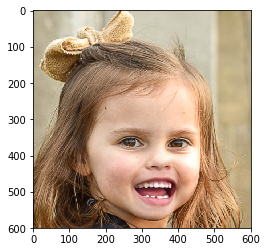

In [12]:
import matplotlib.pyplot as plt
plt.imshow(images_df.images[1])

In [7]:
images_df['id'] = images_df['id'].str.split('.').str[0]
images_df.head()

,images,id
0,"[[[254, 254, 254], [254, 254, 254], [254, 254,...",00217efccd6f697eb937
1,"[[[175, 165, 138], [176, 166, 139], [177, 167,...",020c00becfcd4e7938af
2,"[[[192, 128, 162], [189, 125, 159], [188, 124,...",0616140ccf8da205dae1
3,"[[[231, 232, 234], [231, 232, 234], [232, 233,...",046d3ccaf5e4888cff8f
4,"[[[128, 157, 187], [129, 158, 188], [130, 159,...",01a1a6b856bffedc304c


Id's are cleaned and got their appropriate form for submission.

## 3. Models

### 3.1. Benchmark Model

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2 
import os 
from random import shuffle 
from tqdm import tqdm 
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
import os

In [ ]:
train_real_dir = "drive/My Drive/data/training/a_real/"
train_fake_dir= "drive/My Drive/data/training/fake/"
test_real_dir= "drive/My Drive/data/validation/a_real"
test_fake_dir= "drive/My Drive/data/validation/fake"
image_size=600



In [ ]:
def train_data():
    train_data_real = [] 
    train_data_fake=[]
    for image1 in tqdm(os.listdir(train_real_dir)): 
        path = os.path.join(train_real_dir, image1)
        img1 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img1 = cv2.resize(img1, (image_size, image_size))
        train_data_real.append(img1) 
    for image2 in tqdm(os.listdir(train_fake_dir)): 
        path = os.path.join(train_fake_dir, image2)
        img2 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img2 = cv2.resize(img2, (image_size, image_size))
        train_data_fake.append(img2) 
    
    train_data= np.concatenate((np.asarray(train_data_real),np.asarray(train_data_fake)),axis=0)
    return train_data

In [ ]:
def test_data():
    test_data_real = [] 
    test_data_fake=[]
    for image1 in tqdm(os.listdir(test_real_dir)): 
        path = os.path.join(test_real_dir, image1)
        img1 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img1 = cv2.resize(img1, (image_size, image_size))
        test_data_real.append(img1) 
    for image2 in tqdm(os.listdir(test_fake_dir)): 
        path = os.path.join(test_fake_dir, image2)
        img2 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img2 = cv2.resize(img2, (image_size, image_size))
        test_data_fake.append(img2) 
    
    test_data= np.concatenate((np.asarray(test_data_real),np.asarray(test_data_fake)),axis=0)
    return test_data

Functions for loading the training data and test data are written.

In [24]:
train_data = train_data() 
test_data = test_data()

100%|██████████| 100/100 [00:01<00:00, 61.84it/s]


Training and test data are loaded.

In [ ]:
X=np.concatenate((train_data,test_data),axis=0)
X = (X-np.min(X))/(np.max(X)-np.min(X))

Data is rescaled.

In [ ]:
r = np.zeros(721)
f = np.ones(363)
Y_train = np.concatenate((r, f), axis=0)
r = np.zeros(170)
f = np.ones(100)
Y_test = np.concatenate((r, f), axis=0)

Labels for training and test data are created.

In [ ]:
y=np.concatenate((Y_train,Y_test),axis=0).reshape(X.shape[0],1)


In [28]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
number_of_train = x_train.shape[0]
number_of_test = x_test.shape[0]
print("Amount of train data : ", number_of_train, ".  Amount of test data : ", number_of_test)

Amount of train data :  1083 .  Amount of test data :  271


Merged data is splitted into training and test data.

In [29]:
print(x_train.shape,y_train.shape)

(1083, 600, 600) (1083, 1)


In [30]:
x_train_flatten = x_train.reshape(number_of_train,x_train.shape[1]*x_train.shape[2])
x_test_flatten = x_test .reshape(number_of_test,x_test.shape[1]*x_test.shape[2])
x_train = x_train_flatten.T
x_test = x_test_flatten.T
y_test = y_test.T
y_train = y_train.T
print("x train: ",x_train.shape)
print("x test: ",x_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (360000, 1083)
x test:  (360000, 271)
y train:  (1, 1083)
y test:  (1, 271)


Data is reshaped. 

In [31]:
from sklearn.linear_model import LogisticRegression
log_reg= LogisticRegression(C=1,penalty="l1")
log_reg.fit(x_train.T,y_train.T)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Logistic regression is used for benchmark since the task is binary classification.

In [32]:
print("test accuracy: {} ".format(log_reg.score(x_test.T, y_test.T)))
print("train accuracy: {} ".format(log_reg.score(x_train.T, y_train.T)))

test accuracy: 0.6162361623616236 
train accuracy: 0.9926131117266851 


Train accuracy is high but test accuracy is low. 

### 3.2. Basic CNN Model

In [20]:
from keras.models import Sequential,Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Dropout 
from keras.layers import Conv2D 
from keras.layers import MaxPooling2D,GlobalAveragePooling2D
model = Sequential() 
model.add(Conv2D(32,
                 kernel_size=(3, 3),
                 activation='relu', 
                 input_shape=(img_height,img_width,3))) 
model.add(MaxPooling2D()) 
model.add(Conv2D(32, (3,3), activation='relu',strides=(2,2),kernel_initializer='glorot_normal' ,padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), activation='relu',strides=(2,2),kernel_initializer='glorot_normal',padding="same"))
model.add(Conv2D(32, (3, 3), activation='relu',strides=(2,2),kernel_initializer='glorot_normal',padding="same"))
model.add(Flatten())
model.add(Dense(16, activation='relu',kernel_initializer='glorot_normal')) 
model.add(Dense(1, activation='sigmoid')) 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 598, 598, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 299, 299, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 38, 38, 32)        9248      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 19, 19, 32)        9248      
_________________________________________________________________
flatten_3 (Flatten)          (None, 11552)             0         
__________

A basic CNN model is built. Kernel size is set to 3. Strides are set to 2. Glorot normal initializer is used for kernel initializer. Padding is set to same. Relu is used as activation function. 

After several Conv2D layers,  fully connected layers are built to make classification. Since our aim is binary classification, the last Dense layer has 1 unit and sigmoid as activation function. This layer gives the probability of being fake for a photo.

In [ ]:
def auc_roc(y_true, y_pred):
   
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)

    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

To be able to monitor the auc scores for each epoch, a custom auc_roc function is used.

In [21]:
from keras.optimizers import Adam

epochs=15
val_steps=len(val_data)/batch_size
steps_per_epoch=n_train_samples/batch_size
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy',auc_roc])
history=model.fit_generator(train_data,
          steps_per_epoch= steps_per_epoch,validation_steps=val_steps,
          epochs=epochs,
          verbose=1,
          validation_data=val_data)

Epoch 1/15
34/33 [==============================] - 98s 3s/step - loss: 0.6518 - acc: 0.6543 - auc_roc: 0.4922 - val_loss: 0.6384 - val_acc: 0.6875 - val_auc_roc: 0.4895
Epoch 2/15
34/33 [==============================] - 96s 3s/step - loss: 0.6399 - acc: 0.6650 - auc_roc: 0.4994 - val_loss: 0.6188 - val_acc: 0.6875 - val_auc_roc: 0.5029
Epoch 3/15
34/33 [==============================] - 97s 3s/step - loss: 0.6388 - acc: 0.6650 - auc_roc: 0.5060 - val_loss: 0.7866 - val_acc: 0.5625 - val_auc_roc: 0.5102
Epoch 4/15
34/33 [==============================] - 97s 3s/step - loss: 0.6448 - acc: 0.6648 - auc_roc: 0.5077 - val_loss: 0.6257 - val_acc: 0.7188 - val_auc_roc: 0.5100
Epoch 5/15
34/33 [==============================] - 97s 3s/step - loss: 0.6358 - acc: 0.6656 - auc_roc: 0.5147 - val_loss: 0.7103 - val_acc: 0.5625 - val_auc_roc: 0.5173
Epoch 6/15
34/33 [==============================] - 96s 3s/step - loss: 0.6337 - acc: 0.6653 - auc_roc: 0.5193 - val_loss: 0.5537 - val_acc: 0.7812 - 

In [ ]:
import matplotlib.pyplot as plt
def show_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'val_accuracy'], loc='best')
    plt.show()



show_history function plots accuracy in y axis and number of epochs in x axis for both training and validation data.

In [ ]:
def show_loss(history):
  plt.title('Loss')
  plt.plot(history.history['loss'], label='train_loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.legend()
  plt.show()



show_loss function plots loss in y axis and number of epochs in x axis for both training and validation data.

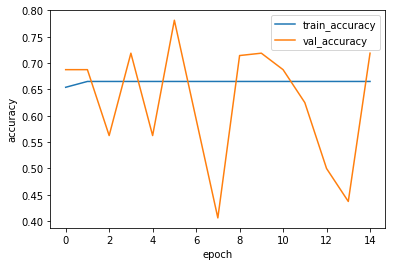

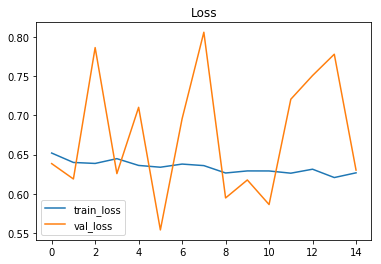

In [24]:
show_history(history)
show_loss(history)

Adam with learning rate 0.001 is selected as optimizer. Binary crossentropy is used for loss since this is a binary classification task. Accuracy and auc scores are used for metrics.

The model is trained for 15 epochs and training accuracy does not increase. This means that this model is too basic for this task. More complex models are needed.

### 3.3. VGG16 Transfer Learning

Deep convolutional models are needed for image classification tasks. However, these models require huge amounts of computation power. Therefore, transfer learning is used instead training the whole model. Keras library provides several pretrained models for us. Most famous ones are ResNet and VGG. For image recognition tasks, ResNet models are more suitable [4]. For binary classification tasks, VGG models are used in general [5]. Therefore VGG16 is chosen and used for this task. 

In [25]:
from keras.models import Sequential,Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Dropout 
from keras.layers import Conv2D 
from keras.layers import MaxPooling2D,GlobalAveragePooling2D,BatchNormalization
import keras.applications,keras
from keras import regularizers
base_model_vgg16=keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(img_height,img_width,3),
                                                 backend = keras.backend, 
                                                 layers = keras.layers,
                                                 models = keras.models,
                                                 utils = keras.utils)
for layer in base_model_vgg16.layers[:15]:
    layer.trainable = False
x=base_model_vgg16.output
x=Flatten()(x)
x=Dense(32,activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(32,activation='relu')(x)
x=Dropout(0.2)(x)
predictions_vgg16 = Dense(1, activation= 'sigmoid')(x)
my_VGG16 = Model(inputs = base_model_vgg16.input, outputs = predictions_vgg16)
my_VGG16.summary()
#en iyi modelin 100 epochs lr=1e-4, tek dense 16 unit.

W0816 11:59:50.272747 140318564321152 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 600, 600, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 600, 600, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 600, 600, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 300, 300, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 300, 300, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 300, 300, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 150, 150, 128)     0         
__________

Pretrained VGG16 model is imported. ImageNet weights are used and the last part of VGG16 model is excluded by setting include_top=False. This way, custom fully connected layers can be built on top of VGG16 model. 

All the layers of VGG16 model are frozen except the last convolutional block which consist of 3 Conv2D layers. This last block can capture important features from the images, therefore it is left trainable. 

Fully connected layers are built on top of VGG16. To prevent overfitting, dropouts are added. 

Several fully connected layer designs are used and best one among them are chosen. This model is not the chosen one.



In [35]:

from keras.preprocessing.image import ImageDataGenerator 
from keras.applications.vgg16 import preprocess_input
batch_size=16
img_height=600
img_width=600

generator = ImageDataGenerator(
                               validation_split=0, 
                              rotation_range = 10, 
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               zoom_range = 0.1,
                               horizontal_flip = True,
                               preprocessing_function=preprocess_input) 

val_generator=ImageDataGenerator(preprocessing_function=preprocess_input)

train_data = generator.flow_from_directory(
    bn_root_path_training,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
    ) 

val_data = val_generator.flow_from_directory(
    bn_root_path_validation, 
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 1084 images belonging to 2 classes.
Found 270 images belonging to 2 classes.


Training and validation data is loaded. Instead of rescaling the images, preprocessing function for VGG16 model is imported and used both for training and validation data. 

Only training data is augmented by some arguments.

In [ ]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_data = test_gen.flow(np.array(list(images_df.images)), batch_size=1,shuffle=False)

Test data is loaded. Preprocess_input from VGG16 is used for preprocessing_funciton.

In [ ]:
from keras.optimizers import Adam,SGD

my_VGG16.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy',auc_roc])


Adam with learning rate 0.0001 is selected as optimizer. Binary crossentropy is used for loss since this is a binary classification task. Accuracy and auc scores are used for metrics.

In [37]:
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
epochs=25


val_steps=270/batch_size
steps_per_epoch=n_train_samples/batch_size
checkpoint=ModelCheckpoint('VGG16-transferlearning_2dense32bs32lr1e4.model', monitor='val_acc', save_best_only=True)

history_VGG16=my_VGG16.fit_generator(train_data,
                                 steps_per_epoch= steps_per_epoch,
                                 validation_steps=val_steps,
                                 epochs=epochs,
                                 verbose=1,
                               validation_data=val_data,
                               callbacks=[ModelCheckpoint('VGG16-transferlearning_2dense32bs32lr1e4.model', monitor='val_acc', save_best_only=True)])


Epoch 1/25
68/67 [==============================] - 140s 2s/step - loss: 0.7872 - acc: 0.5803 - auc_roc: 0.4481 - val_loss: 0.6629 - val_acc: 0.6296 - val_auc_roc: 0.4699
Epoch 2/25
68/67 [==============================] - 109s 2s/step - loss: 0.6697 - acc: 0.6348 - auc_roc: 0.4763 - val_loss: 0.6455 - val_acc: 0.6259 - val_auc_roc: 0.4863
Epoch 3/25
68/67 [==============================] - 108s 2s/step - loss: 0.6377 - acc: 0.6437 - auc_roc: 0.5034 - val_loss: 0.6668 - val_acc: 0.6222 - val_auc_roc: 0.5148
Epoch 4/25
68/67 [==============================] - 109s 2s/step - loss: 0.6404 - acc: 0.6562 - auc_roc: 0.5208 - val_loss: 0.6457 - val_acc: 0.6296 - val_auc_roc: 0.5301
Epoch 5/25
68/67 [==============================] - 108s 2s/step - loss: 0.6358 - acc: 0.6440 - auc_roc: 0.5377 - val_loss: 0.6773 - val_acc: 0.5963 - val_auc_roc: 0.5456
Epoch 6/25
68/67 [==============================] - 109s 2s/step - loss: 0.6211 - acc: 0.6805 - auc_roc: 0.5550 - val_loss: 0.6882 - val_acc: 0.5

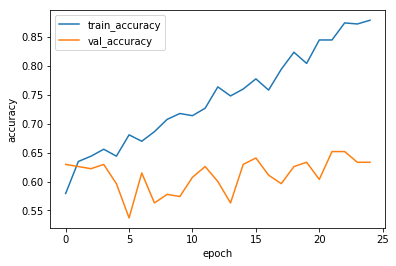

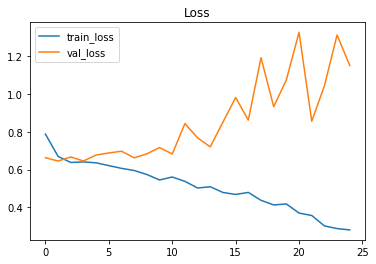

In [38]:
show_history(history_VGG16)
show_loss(history_VGG16)

The model is trained for 25 epochs. There is overfitting and validation accuracy stays the same from the beginning. So, this model cannot be used for predictions.

In [48]:
from keras.models import Sequential,Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Dropout 
from keras.layers import Conv2D 
from keras.layers import MaxPooling2D,GlobalAveragePooling2D,BatchNormalization
import keras.applications,keras
from keras import regularizers
base_model_vgg16=keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(img_height,img_width,3),
                                                 backend = keras.backend, 
                                                 layers = keras.layers,
                                                 models = keras.models,
                                                 utils = keras.utils)
for layer in base_model_vgg16.layers[:15]:
    layer.trainable = False
x=base_model_vgg16.output
x=Flatten()(x)
x=Dense(16,activation='relu')(x)
x=Dropout(0.2)(x)
predictions_vgg16 = Dense(1, activation= 'sigmoid')(x)
my_VGG16 = Model(inputs = base_model_vgg16.input, outputs = predictions_vgg16)
my_VGG16.summary()


W0816 15:40:02.922920 140509531211648 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 600, 600, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 600, 600, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 600, 600, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 300, 300, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 300, 300, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 300, 300, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 150, 150, 128)     0         
__________

Although this design is very simple, the best one among all the models is this one. 

In [ ]:
from keras.optimizers import Adam,SGD

my_VGG16.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy',auc_roc])


This model was trained and saved. It is trained for 25 epochs using optimizer Adam with learning rate 0.0001 and batch size 32.

In [63]:
train_data = generator.flow_from_directory(
    bn_root_path_training,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary'
    ) 

val_data = val_generator.flow_from_directory(
    bn_root_path_validation, 
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary')

Found 1084 images belonging to 2 classes.
Found 270 images belonging to 2 classes.


Training and validation data are loaded again with batch size 32.

In [65]:
print("Training accuracy is : ", my_VGG16.evaluate_generator(train_data,steps=1084/32,workers=0)[0])
print("\n\n")
print("Validation accuracy is : " , my_VGG16.evaluate_generator(val_data,steps=270/32,workers=0)[0])



Training accuracy is :  0.6934206246010052



Validation accuracy is :  0.7532701002226936


The saved model is loaded. The predictions for  training and validation data are obtained. to calculate accuracy for both.


Both training and validation accuracy are the best ones obtained from all the trained models. Thus, this model is selected for predictions.

In [27]:
images_df["predictions"]=np.ones(len(images_df.images),dtype=int)*2
images_df.tail(1)

,images,id,predictions
480,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",fd2807a7befa288f3321,2


In [33]:
images_df.predictions=my_VGG16.predict_generator(test_data,steps=len(images_df.images),workers=0)
images_df.predictions[images_df.predictions<0.5]=0
images_df.predictions[images_df.predictions>=0.5]=1
print("Total number of predicted fake photos: " , images_df.predictions.sum())

Total number of predicted fake photos:  171.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
submission=pd.DataFrame()
submission["ID"]=images_df.id
submission["fake"]=images_df.predictions.astype(int)
submission.head()

,ID,fake
0,00217efccd6f697eb937,1
1,020c00becfcd4e7938af,0
2,0616140ccf8da205dae1,0
3,046d3ccaf5e4888cff8f,1
4,01a1a6b856bffedc304c,0


In [ ]:
submission.to_csv("submission_VGG16-transferlearning_final?", encoding='utf-8', index=False)

Predictions are stored in images_df. Since the order is preserved when loading test data, predictions match with the corresponding data. 

Finally, predictions are saved in a csv file.

### 4. Conclusion

In conclusion, several models are tried and best one among them is used to predict labels for this task. Deep convolutional networks are powerful networks. Like in other tasks, a deep convolutional network , which is a VGG16 with fully connected layer on top, outperformed the benchmark model in this project. 

### 5. References

1. Alex Krizhevsky, Ilya Sutskever, and Geoffrey E. Hinton, ImageNet Classification with Deep Convolutional Neural Networks, Advances in Neural Information Processing Systems, September 2012.
2. Jason Yosinski, Jeff Clune, Yoshua Bengio, and Hod Lipson, How transferable are features in deep neural networks?, Advances in Neural Information Processing Systems, 
November 2014.
3. Luis Perez, Jason Wang, The Effectiveness of Data Augmentation in Image Classification using Deep Learning,  December 2017.
4. Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun, Deep Residual Learning for Image Recognition, December 2015.
5. Mikhail Krinitskiy, Polina Verezemskaya, Kirill Grashchenkov, Natalia Tilinina, Sergey Gulev and Matthew Lazzara,  Molecular Diversity Preservation International, October 2018.